In [1]:
#!/bin/env python
import numpy as np
from tqdm import trange, tqdm
from gmpy2 import hamdist
from itertools import product, combinations

def ctz(d:int) -> int:
    '''
    count trailing zero bits
    https://graphics.stanford.edu/~seander/bithacks.html#ZerosOnRightLinear
    '''
    if d:
        v = ((d ^ (d - 1)) >> 1)  # Set v's trailing 0s to 1s and zero rest
        trailing = 0
        while v:
            v >>= 1
            trailing += 1
        return trailing
    return 64

def inext(v: int) -> int:
    '''
    get next integer that has the same popcount as v
    https://graphics.stanford.edu/~seander/bithacks.html#NextBitPermutation
    '''
    t = v | (v-1)
    w = (t+1) | (((~t & -~t) - 1) >> (ctz(v) + 1))
    return w

def detlist(nmo:int, nelec:int):
    '''
    generate list of all possible determinants with ne electrons in mo orbitals
    represented as integers (1->occupied, 0->virtual)
    '''
    di=(1<<nelec)-1
    dmax=di<<(nmo-nelec)
    dets=[]
    while (di<=dmax):
        dets.append(di)
        di=inext(di)
    return dets

def hmat_from_dets(dets):
    ndet = len(dets)
    # we know diagonal elements are nonzero, so start from identity matrix
    H = np.eye(ndet, dtype=bool)
    # H is symmetric, so just loop over upper (or lower) triangle
    for i, j in tqdm(combinations(range(0,ndet), 2), total=ndet*(ndet-1)/2):
        x = dets[i]
        y = dets[j]
        # hamdist(x,y) is equivalent to popcount(x^y), number of bits where x,y differ
        e = hamdist(x,y)
        if e < 5:
            H[i, j] = 1
            H[j, i] = 1
    return H

def hmat(nmo,nelec):
    return hmat_from_dets(detlist(nmo,nelec))

mo=18
ne=4
H = hmat(mo,ne)

100%|██████████| 4680270/4680270.0 [00:02<00:00, 1964319.42it/s]


In [2]:
from numpy import count_nonzero
print("Sparsity:", count_nonzero(H)/float(H.size))

def nsingles(nmo:int, nelec:int):
    return nelec*(nmo-nelec)

def ndoubles(nmo:int, nelec:int):
    nvirt = nmo - nelec
    return (nelec*(nelec-1))//2 * (nvirt*(nvirt-1))//2

def fci_ndet(nmo:int,nelec:int):
    from scipy.special import comb
    return comb(nmo,nelec,exact=True)

def fci_sparsity(nmo:int,nelec:int):
    return (1 + nsingles(nmo,nelec) + ndoubles(nmo,nelec))/fci_ndet(nmo,nelec)


print("Sparsity:", fci_sparsity(mo,ne))

    

Sparsity: 0.19705882352941176
Sparsity: 0.19705882352941176


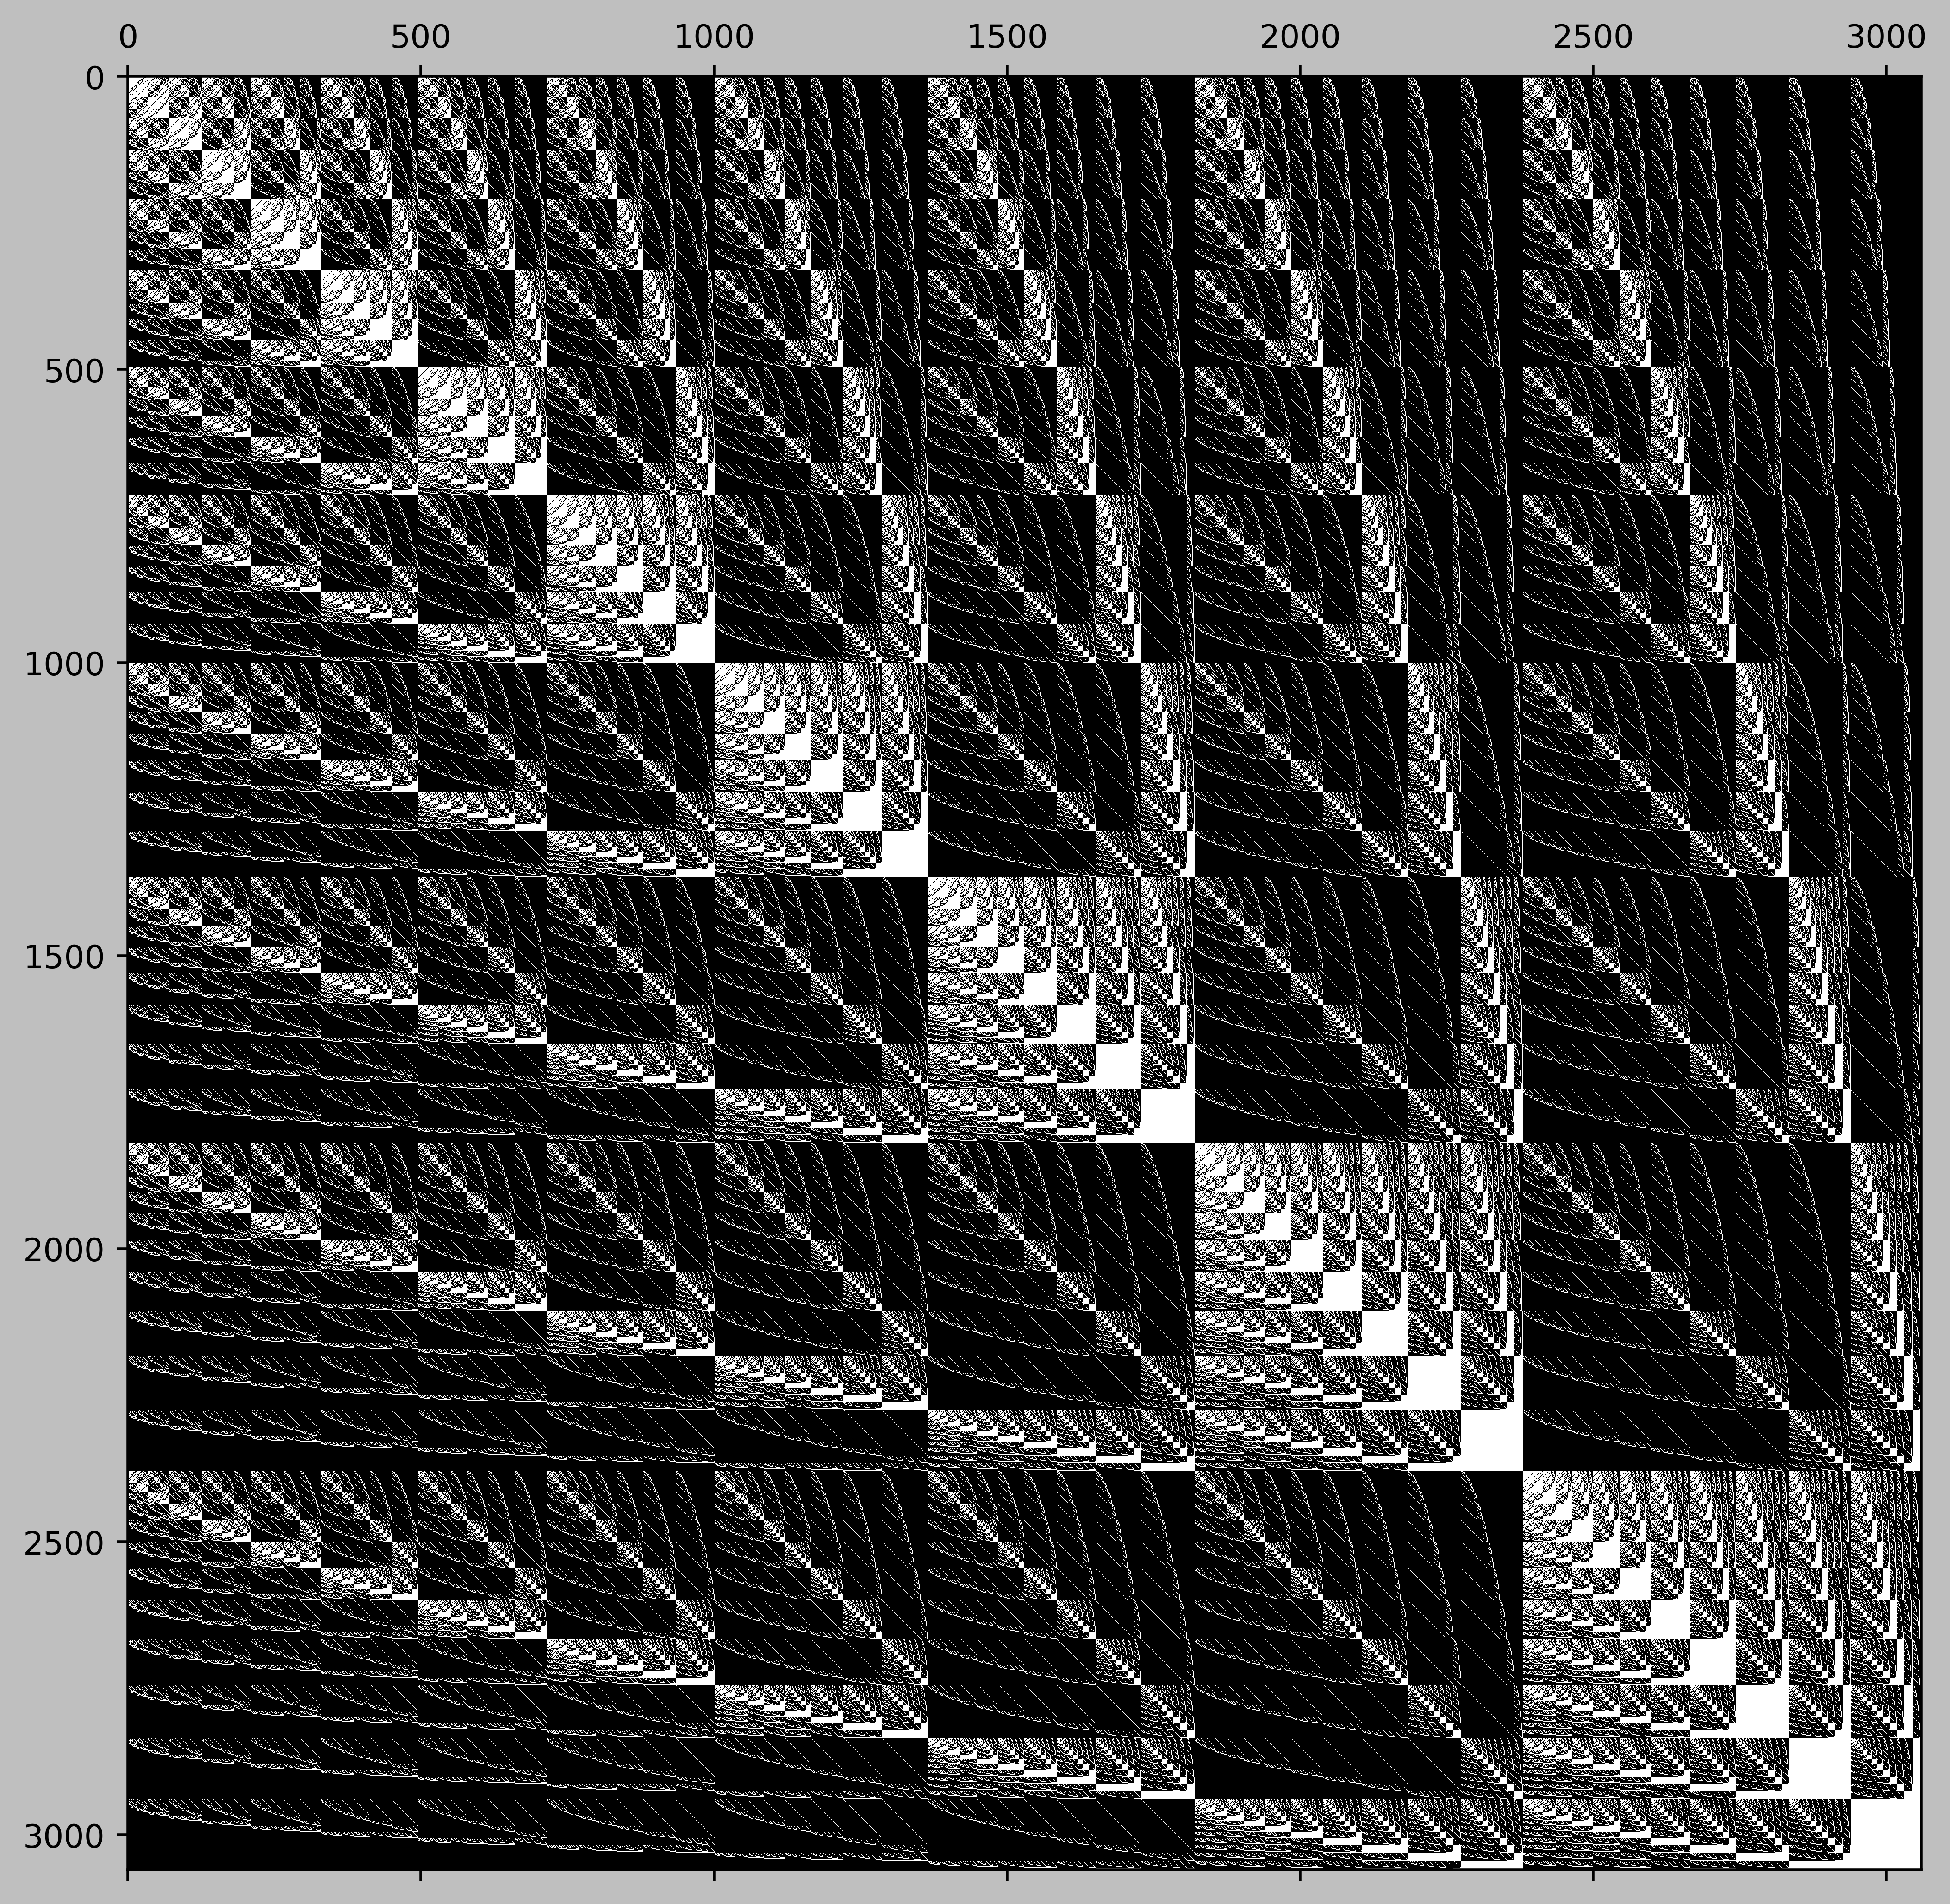

In [3]:
import matplotlib.pyplot as plt

plt.style.use('grayscale')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 500
plt.matshow(H)

In [4]:
plt.show()